In [694]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

We read in our csv. This corresponds to the pre-processed eBird data for a selection of 24 different species within the Amazonas state of Brazil (specifically filtered down to the four sites we selected) between the years 2012-2021 (the years we cover are influenced by what climate/environmental data we have). See the files 'pre-ebird_pre_preprocessing_example.Rmd' and 'pre-selecting_sites_and_species.ipynb' for other details on the preprocessing steps.

In [1324]:
birds = pd.read_csv('birds_final.csv')

We will also need some of the raw climate data, contained in the file 'clim_raw.csv'. Note that this data has already been joined into the eBird/habitat data contained within birds. But for part of our analysis we will also need entries that were not joined in - more details below.

In [1326]:
clim_raw = pd.read_csv('clim_raw.csv')

In [233]:
# Just a quick view of the main birds dataframe
birds.head()

,checklist_id,state_code,locality_id,latitude,longitude,observation_date,protocol_type,duration_minutes,effort_distance_km,number_observers,...,Shape_Area,Site_ID,X_coord,Y_coord,tmax,tmin,prec,EVI,umd_tree_cover_loss_ha,umd_tree_cover_loss_from_fires_ha
0,S130090237,BR-AM,L2872043,-3.062795,-60.107907,2012-02-11,Traveling,60.0,0.5,6.0,...,1.867389e+10,69.0,-59.705321,-3.261773,29.0,23.19,291.3,0.464591,163604.2673,25449.43001
1,S130090237,BR-AM,L2872043,-3.062795,-60.107907,2012-02-11,Traveling,60.0,0.5,6.0,...,1.867389e+10,69.0,-59.705321,-3.261773,29.0,23.19,291.3,0.464591,163604.2673,25449.43001
2,S130090237,BR-AM,L2872043,-3.062795,-60.107907,2012-02-11,Traveling,60.0,0.5,6.0,...,1.867389e+10,69.0,-59.705321,-3.261773,29.0,23.19,291.3,0.464591,163604.2673,25449.43001
3,S130090237,BR-AM,L2872043,-3.062795,-60.107907,2012-02-11,Traveling,60.0,0.5,6.0,...,1.867389e+10,69.0,-59.705321,-3.261773,29.0,23.19,291.3,0.464591,163604.2673,25449.43001
4,S130090237,BR-AM,L2872043,-3.062795,-60.107907,2012-02-11,Traveling,60.0,0.5,6.0,...,1.867389e+10,69.0,-59.705321,-3.261773,29.0,23.19,291.3,0.464591,163604.2673,25449.43001


In [1327]:
# Here are all the columns currently in the dataframe. We will only be using a subset of these
birds.columns

Index(['checklist_id', 'state_code', 'locality_id', 'latitude', 'longitude',
       'observation_date', 'protocol_type', 'duration_minutes',
       'effort_distance_km', 'number_observers', 'scientific_name',
       'observation_count', 'species_observed', 'effort_hours',
       'effort_speed_kmph', 'hours_of_day', 'year', 'day_of_year', 'Family',
       'Order_', 'Habitat', 'Habitat_Density', 'Migration', 'Trophic_Level',
       'Trophic_Niche', 'Primary_Lifestyle', 'Guild', 'Sp_Gen', 'SNST',
       'STRAT', 'REL', 'Unique_ID', 'Site_ID_1', 'OBJECTID', 'Shape_Length',
       'Shape_Area', 'Site_ID', 'X_coord', 'Y_coord', 'tmax', 'tmin', 'prec',
       'EVI', 'umd_tree_cover_loss_ha', 'umd_tree_cover_loss_from_fires_ha'],
      dtype='object')

In [235]:
# Quick view of the climate dataframe
clim_raw.head()

,Unnamed: 0,Lat,Long,prec,Date,Site_ID,tmin,tmax
0,0,-3.25,-61.25,434.34,2000-01-01,68,22.5,30.0
1,1,-3.25,-61.25,339.41,2000-02-01,68,23.0,30.0
2,2,-3.25,-61.25,364.26,2000-03-01,68,23.0,30.0
3,3,-3.25,-61.25,420.14,2000-04-01,68,23.0,30.0
4,4,-3.25,-61.25,278.97,2000-05-01,68,23.0,31.0


In [1328]:
# Modification to convert the 'observation_date' column of birds and the 'Date' column of clim_raw to
# DateTime objects
birds['observation_date'] = pd.to_datetime(birds['observation_date'], format='%Y-%m-%d')
clim_raw['Date'] = pd.to_datetime(clim_raw['Date'], format='%Y-%m-%d')

Of the current columns in the dataframe, below are lists of those variables (covariates) we are interested in, divided into three categories. 
-  occupancy_covs: These are occupancy covariates, features that could influence whether or not a species occupies a site on an ecological level (e.g. 'umd_tree_cover_loss_ha' tells us about the tree-cover loss. Fewer trees might make it less likely that a given species occupies a particular site.)
<br>


- detection_covs: These are covariates related to species detection, rather than species occupancy, e.g. features related to the effort level and circumstances of a particular observation outing (e.g. 'effort_hours' tells us how long the observers spent looking for birds on a given day)
<br>

Note that we are intereseted in modeling the effects of the occupancy covariates over time, so we will have to take into account the temporal nature of those features. We will not do the same for the detection covariates.

In [1329]:
occupancy_covs = ['prec', 'tmax', 'tmin', 'EVI','umd_tree_cover_loss_ha', 'umd_tree_cover_loss_from_fires_ha']
trait_covs = ['Trophic_Niche', 'Sp_Gen', 'SNST', 'REL', 'Primary_Lifestyle']
detection_covs = ['observation_date', 'effort_distance_km', 'number_observers', 'effort_hours', 'year', 
               'day_of_year', 'hours_of_day']

In [1330]:
# Trim down the dataframe to just columns we want
all_cols = occupancy_covs + trait_covs + detection_covs + ['checklist_id', 'scientific_name', 
                                                        'species_observed', 'Site_ID']
birds = birds[all_cols]

Note that the 'species_observed' in the cell above is a binary variable denoting whether or not a species was detected. If True, the species was detected. If False, the species was not detected. 

**<center>In the machine-learning/classification approach employed in this notebook, we are implicitly make the approximation that <br> detection = occupancy.<br> This is not strictly true. Occupancy refers to whether or not the species is really there. Detection refers to whether or not you detected it (it could have been there and you just missed it). In other words, we are NOT explicitly modelling occupancy and detection separately here. We are simply modelling detection. That being said, we are including detection covariates in the hope that our models will learn about detection effects and the possibility of imperfect detection as they train, but this is only on an implicit level. At the end of the day, we still predict detection and take that as a proxy for occupancy. That can be a limitation of this modeling approach <br><br>
For details about an alternative approach (Occupancy Modelling) where one does explicitly model detection probability to account for imperfect detection, please see the occupancy modelling section of our project and the related notebook.<center>**



Now we stratify the data based on species. The two species we will be considering are 'Lipaugus vociferans' (screaming piha, a forest specialst) and 'Coragyps atratus' (black vulture, a generalist).

In [1331]:
species = ['Lipaugus vociferans', 'Coragyps atratus']

In [1332]:
birds_lip_v = birds.loc[birds.scientific_name == species[0]].sort_values(by='observation_date')
birds_cor_a = birds.loc[birds.scientific_name == species[1]].sort_values(by='observation_date')

In the last cell, we also made sure that everything was sorted by observation_date. So we'll go ahead and set aside the last 20% of each species' dataframe for a test set. 

In [1334]:
birds_lip_v_test = birds_lip_v.tail(int(len(birds_lip_v)*0.2)).copy()
birds_lip_v_train = birds_lip_v.head(len(birds_lip_v) - int(len(birds_lip_v)*0.2)).copy()

birds_cor_a_test = birds_cor_a.tail(int(len(birds_cor_a)*0.2)).copy()
birds_cor_a_train = birds_cor_a.head(len(birds_cor_a) - int(len(birds_cor_a)*0.2)).copy()

We're interested in taking a set of features (covariates) and predicting the occupancy status (the target name in our dataframe is 'species_observed') for some bird species at a given site. In that sense, we're thinking about this as a supervised learning (classification) problem, not a pure time series problem. Then we need to take the data that have a time series element (the occupancy covariates) and turn them into features for supervised learning. We will do this by creating shifted features, so that for a particular observation/checklist, we have ***a new feature holding the value of our occupancy covariate at the previous time step.*** Because the environmental and climate data we were able to obtain have different frequencies (e.g. EVI is measured yearly while precipitation is measured monthly), the shifts for each of the features will be done at these different frequencies as well. Full details are below:

 - Shift 'EVI', 'umd_tree_cover_loss_ha', and 'umd_tree_cover_loss_from_fires_ha' by 1 year. The expectation is that past ecological conditions should influence whether or not a species presently occupies a site.
 - Shift 'tmax', 'tmin', and 'prec' by 1 month. Similar expectation to the above, that climate conditions in the past should influence whether or not a species presently occupies a site.
 - Shift species_observed by one previous observation. Note this could be as short as a single day or potentially much longer if no observations had been carried out recently. Also note that if there are multiple observations on the same day, we shift them both to the previous observation (in other words our finest resolution for this feature is daily). The expectation here is that we should have some kind of temporal autocorrelation. That is, the fact that a species was detected at a site the last time someone looked likely influences the probability that the species will be detected the next time someone looks. The hope is that passing this as a feature into our models will help them find and account for this autocorrelation, rather than being fooled by it. 

So in summary, for a given eBird observation we will know:
- 'EVI', 'umd_tree_cover_loss_ha', and 'umd_tree_cover_loss_from_fires_ha' from the previous year
- 'tmax', 'tmin', and 'prec' for the previous month
- and occupancy status ('species_observed') for the most recent time the bird was looked for

Below are some functions to do these things for our data set. Note we will do this separately for each species we consider.

In [1337]:
# Function to create new (shifted) columns corresponding to 'EVI', 'umd_tree_cover_loss_ha',
# and 'umd_tree_cover_loss_from_fires_ha' from the previous year
def yearly_cov_shift(df_in):
    '''
    Takes our eBird dataframe and shifts the occupancy covariates for which data is yearly by 1 year. 
    Note these covariates are 'EVI', 'umd_tree_cover_loss_ha', and 'umd_tree_cover_loss_from_fires_ha'
    
    df_in: dataframe
    returns dataframe with new columns corresponding to yearly-shifted features
    '''
    df = df_in.sort_values(by='observation_date').copy()
    covs = ['EVI', 'umd_tree_cover_loss_ha', 'umd_tree_cover_loss_from_fires_ha']
    sites = df.Site_ID.unique()
    for cov in covs:
        for site in sites:
            year_start = df.loc[df.Site_ID == site, 'observation_date'].min().year
            # Handle the first year, whose shifted column will be populated with nan
            df.loc[(df.observation_date.dt.year == year_start) & (df.Site_ID == site), cov+str('_prev_yr')] = np.nan
            # Now handle the rest of the years
            for year in df.observation_date.dt.year.unique()[1:]:
                df.loc[(df.observation_date.dt.year == year) & (df.Site_ID == site), cov+str('_prev_yr')] = df.loc[(df.observation_date.dt.year == year - 1) & (df.Site_ID == site), cov].unique()[0]      
    return df

Next we will handle the monthly-shifted variables. Note that for this to work, we need the raw climate data in the dataframe clim_raw. The climate data was already joined into the main eBird data in the datafram birds, but there are some months without any eBird observations. Thus for those months our birds dataframe does not contain the climate data. Nevertheless for any month with no observations, the next month may indeed have observations and so we still need the climate data for that month even though it doesn't correspond to an eBird observation.

In [1338]:
# Function to create new (shifted) columns corresponding to 'tmax', 'tmin', and 'prec' from the previous month.
# Note that this function requires the climate data in 'clim_raw'
def monthly_cov_shift(df_in):
    '''
    Takes our eBird dataframe and shifts the occupancy covariates for which data is monthly by one month. 
    Note these covariates are 'tmax', 'tmin', and 'prec'
    Note - Relies on the additional dataframe 'clim_raw' which has the raw data for these three monthly covariates.
    The reason is that the eBird data has some months with no checklists. So even though we have already joined 
    the climate data to the main eBird data, the process of joining this monthly covariate data onto the eBird 
    dataframe only populates those months which do have checklists. But we still have access to the full scope of 
    monthly data for these covariates, even when there is no eBird checklist for a iven month. 
    So we use the raw covariate data contained in 'clim_raw' here.
    
    df_in: dataframe
    returns dataframe with new columns corresponding to monthly-shifted features
    '''
    df = df_in.sort_values(by='observation_date').copy() # Sort chronologically, reset indices, and copy
    covs = ['tmax', 'tmin', 'prec']
    sites = df.Site_ID.unique()
    for cov in covs:
        for site in sites:
            # Handle the first year
            year_start = df.loc[df.Site_ID == site, 'observation_date'].min().year
            # Find and handle the first month, whose shifted column will be populated with nan
            first_month = df.loc[(df.Site_ID == site) & (df.observation_date.dt.year == year_start), 'observation_date'].min().month
            df.loc[(df.Site_ID == site) & (df.observation_date.dt.year == year_start) & (df.observation_date.dt.month == first_month), cov+str('_prev_month')] = np.nan
            # Handle the rest of the months in the first year
            for month in np.arange(first_month+1, 12 + 1, 1):
                prev_cov = clim_raw.loc[(clim_raw.Site_ID == site) & (clim_raw.Date.dt.year == year_start) & (clim_raw.Date.dt.month == month-1), cov].unique()[0]
                df.loc[(df.Site_ID == site) & (df.observation_date.dt.year == year_start) & (df.observation_date.dt.month == month), cov+str('_prev_month')] = prev_cov   
            # Now move on to the subsequent years
            for year in df.observation_date.dt.year.unique()[1:]:
                for month in np.arange(1,12+1,1):
                    # Get the current and previous month/year (year necessary if the current month is January)
                    current_mo_yr = pd.to_datetime(str(month)+'-'+str(year))
                    if month == 1:
                        prev_mo_yr =  pd.to_datetime('12'+'-'+str(year-1))
                    elif month != 1:
                        prev_mo_yr =  pd.to_datetime(str(month-1)+'-'+str(year))
                    # Now set the shifted column for the current month equal to the equivalent column from the previous month in the 'clim_raw' dataframe
                    prev_cov = clim_raw.loc[(clim_raw.Site_ID == site) & (clim_raw.Date.dt.year == prev_mo_yr.year) & (clim_raw.Date.dt.month == prev_mo_yr.month), cov].unique()[0]
                    df.loc[(df.Site_ID == site) & (df.observation_date.dt.year == current_mo_yr.year) & (df.observation_date.dt.month == current_mo_yr.month), cov+str('_prev_month')] = prev_cov   
    return df

In [1339]:
# Function to create a new (shifted) column corresponding to occupancy ('species_observed') 
# from the previous year. Note that this will not shift all the data by the same frequency since a particular 
# eBird checklist may have another eBird checklist as recently as the day before or perhaps much less recently.
def occ_shift(df_in):
    '''
    Takes our eBird dataframe and shifts the occupancy variable 'species_observed' by 1 distinct observation. 
    Note that this is variable-frequency.
    
    df_in: eBird dataframe
    returns dataframe with new column of shifted occupancy
    '''
    df = df_in.sort_values(by='observation_date').copy() # Sort chronologically, reset the indices, and copy
    sites = df.Site_ID.unique() # List of sites
    for site in sites:
        dates = df.loc[df.Site_ID == site, 'observation_date'].unique() # All the unique observation dates
        # Handle the first observation, whose shifted column will be populated with nan
        df.loc[(df.Site_ID == site) & (df.observation_date == dates[0]), 'species_observed_prev'] = np.nan
        # Loop through the rest of the unique dates
        for i in range(1, len(dates)):
            current_date = dates[i]
            prev_date = dates[i-1]
            # Get the occupancy status from the previous observation. Note that we pull the array of unique values from 
            # the previous date and sum them. The possible unique arrays are True only, False only, or True and False. 
            # In the first two cases, summing the array gives us the same value as the array's element. In the third case
            # (which will happen if there are multiple different checklists on the same day and some of the observers
            # saw the species while others didn't), we'll take this to be true occupancy, so summing the array gives 
            # us True as desired.
            prev_occ = df.loc[(df.observation_date == prev_date) & (df.Site_ID == site), 'species_observed'].unique().sum()
            # Set the shifted column value for the current date to the previous date's occupancy status
            df.loc[(df.Site_ID == site) & (df.observation_date == current_date), 'species_observed_prev'] = prev_occ   
    return df

In [256]:
def get_all_shifts(df_in):
    """Convenience function to get all the shifted features in a single step.
    df_in: eBird dataframe
    returns: dataframe with new columns corresponding to all the temporally-shifted features."""
    
    df_out = occ_shift(monthly_cov_shift(yearly_cov_shift(df_in)))
    df_out = df_out.dropna() # Note that we drop the null values. That is, we drop the first step in our original
                             # 'time-series' since there was no prior data with which we could create a 
                             # shifted feature for that first step.
    df_out.reset_index(drop = True, inplace=True)
    return df_out

Now we are going to fit some models. ***We are going to use a single-species, single-site approach for model selection*** - our model selection will only be done on ***'Lipaugus vociferans' at site 69*** (this site has the most data available). 'Lipaugus vociferans' is our forest specialist, so we can examine how a model selected with data from a specialist generalizes to a generalist by testing our model on 'Coragyps atratus' at the end.

So we're going to shift our occupancy covariates using the function above and then further stratify our data by species and sites (recall there are 4 sites we are considering).

In [1343]:
# first consider just 'Lipaugus vociferans' restricted to site 69
# Shift all our occupancy covariates for time-based prediction
birds_lip_v_train_shifted = get_all_shifts(birds_lip_v_train)
# Pick out just site 69 for the training set
birds_lip_v_train_shifted_69 = birds_lip_v_train_shifted.loc[birds_lip_v_train_shifted.Site_ID == 69].copy()

# Get the shifted test set too and pick out site 69
birds_lip_v_test_shifted = get_all_shifts(birds_lip_v_test)
birds_lip_v_test_shifted_69 = birds_lip_v_test_shifted.loc[birds_lip_v_test_shifted.Site_ID == 69].copy()


In [1344]:
# We'll need the other sites for 'Lipaugus vociferans' to evaluate our model later
birds_lip_v_train_shifted_68 = birds_lip_v_train_shifted.loc[birds_lip_v_train_shifted.Site_ID == 68].copy()
birds_lip_v_train_shifted_79 = birds_lip_v_train_shifted.loc[birds_lip_v_train_shifted.Site_ID == 79].copy()
birds_lip_v_train_shifted_78 = birds_lip_v_train_shifted.loc[birds_lip_v_train_shifted.Site_ID == 78].copy()

birds_lip_v_test_shifted_68 = birds_lip_v_test_shifted.loc[birds_lip_v_test_shifted.Site_ID == 68].copy()
birds_lip_v_test_shifted_79 = birds_lip_v_test_shifted.loc[birds_lip_v_test_shifted.Site_ID == 79].copy()
birds_lip_v_test_shifted_78 = birds_lip_v_test_shifted.loc[birds_lip_v_test_shifted.Site_ID == 78].copy()

# We'll also consider how our models perform on 'Coragyps atratus'
birds_cor_a_train_shifted = get_all_shifts(birds_cor_a_train)

birds_cor_a_train_shifted_69 = birds_cor_a_train_shifted.loc[birds_cor_a_train_shifted.Site_ID == 69].copy()
birds_cor_a_train_shifted_68 = birds_cor_a_train_shifted.loc[birds_cor_a_train_shifted.Site_ID == 68].copy()
birds_cor_a_train_shifted_79 = birds_cor_a_train_shifted.loc[birds_cor_a_train_shifted.Site_ID == 79].copy()
birds_cor_a_train_shifted_78 = birds_cor_a_train_shifted.loc[birds_cor_a_train_shifted.Site_ID == 78].copy()

birds_cor_a_test_shifted = get_all_shifts(birds_cor_a_test)

birds_cor_a_test_shifted_69 = birds_cor_a_test_shifted.loc[birds_cor_a_test_shifted.Site_ID == 69].copy()
birds_cor_a_test_shifted_68 = birds_cor_a_test_shifted.loc[birds_cor_a_test_shifted.Site_ID == 68].copy()
birds_cor_a_test_shifted_79 = birds_cor_a_test_shifted.loc[birds_cor_a_test_shifted.Site_ID == 79].copy()
birds_cor_a_test_shifted_78 = birds_cor_a_test_shifted.loc[birds_cor_a_test_shifted.Site_ID == 78].copy()



Now to fit some models. Recall that we are trying to predict species occupancy (a binary True/False). We'll use two classes of models. 

- ***Binary logistic regression with L1 regularization***
- ***Balanced random forest***
- ***We will also try augmenting these approaches with synthetic minority over-sampling technique (SMOTE) to account for class imbalance between detection and non-detection***

We will evaluate performance using the ***macro-averaged F1 score.*** This is just the simple average of the F1 scores for each of our two classes. Since our goal is to understand whether climate and habitat change have or have not (both cases) impacted species occupancy, we need a metric that accounts for performance on both of our classes. Further, misclassification of either class could lead to incorrect conclusions regarding climate and habitat effects. Similarly a failure to find all members of a class (in particular the Detection Class) would lead to incorrect conclusions regarding these effects. Then to strike a balance between precision and recall for both classes, we opt for the macro-averaged F1 score as our metric to define best performance. <br>

Note that often we will also report the F1 score for just the Detection Class. This is not how we define best performance but it is a useful metric - with small frequencies of Detection relative to Non-Detection, performing well on the Detection Class is difficult, while performing well on the Non-Detection class is fairly easy, even for dummy models. The performance on the Detection Class then offers some direct insight into how our models have improved over baseline predictions. However we still keep the macro-averaged F1 score as our main performance metric since we still wish to retain strong performance on the Non-Detection class. 


In [1356]:
# Import everything we will need
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import f1_score, recall_score, classification_report, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_sample_weight

from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as impipe

In [1357]:
# Define a list of all the features we'll consider
features = ['effort_distance_km', 'number_observers', 'effort_hours', 'year', 'day_of_year', 'hours_of_day',
            'EVI_prev_yr','umd_tree_cover_loss_ha_prev_yr','umd_tree_cover_loss_from_fires_ha_prev_yr',
            'tmax_prev_month','tmin_prev_month', 'prec_prev_month', 'species_observed_prev']

First we will run some dummy classifiers on our data to demonstrate some properties we'll try to handle with our subsequent modeling approaches. We'll show the results for two dummy classifiers. Both dummies completely ignore the features, but they make their guesses in slightly different ways
- Uniform dummy - generates random guesses, treating classes uniformly (binary -> 50/50)
- Stratified dummy - generates random guesses informed by the relative frequencies of the classes

Uniform dummy classifier
               precision    recall  f1-score   support

       False       0.89      0.52      0.66      1533
        True       0.12      0.51      0.19       192

    accuracy                           0.52      1725
   macro avg       0.51      0.52      0.43      1725
weighted avg       0.81      0.52      0.61      1725

Stratified dummy classifier
               precision    recall  f1-score   support

       False       0.89      0.90      0.90      1533
        True       0.11      0.09      0.10       192

    accuracy                           0.81      1725
   macro avg       0.50      0.50      0.50      1725
weighted avg       0.80      0.81      0.81      1725

-----------------------
Class Frequencies:
species_observed
False    0.888696
True     0.111304
Name: proportion, dtype: float64


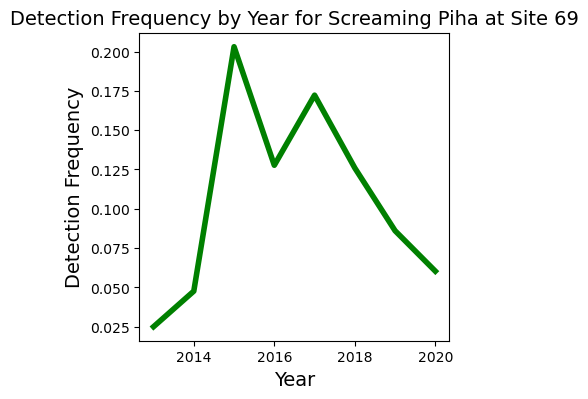

In [1355]:
# Considering just 'Lipaugus vociferans' training data at site 69
data = birds_lip_v_train_shifted_69

#Initialize some dummy classifiers
dummy_uniform = DummyClassifier(strategy = 'uniform') # strategy = 'uniform' -> random guesses
dummy_uniform.fit(data[features], data.species_observed)
dummy_uniform_pred = dummy_uniform.predict(data[features])

dummy_stratified = DummyClassifier(strategy = 'stratified') # strategy = 'stratified' -> random guesses accounting for class frequencies
dummy_stratified.fit(data[features], data.species_observed)
dummy_stratified_pred = dummy_stratified.predict(data[features])
    


print('Uniform dummy classifier\n', classification_report(y_true = data.species_observed, y_pred = dummy_uniform_pred))
print('Stratified dummy classifier\n', classification_report(y_true = data.species_observed, y_pred = dummy_stratified_pred))
print('-----------------------')
print('Class Frequencies:')
print(data.species_observed.value_counts(normalize=True))

det_freqs = []
for year in data.year.unique():
    det_freqs.append(data.loc[data.year == year, 'species_observed'].value_counts(normalize=True)[True] )
fig = plt.figure(figsize = (4,4))
plt.plot(data.year.unique(), det_freqs, c='g', linewidth=4)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Detection Frequency', fontsize = 14)
plt.title('Detection Frequency by Year for Screaming Piha at Site 69', fontsize = 14)
plt.savefig('detectionfreq_lipv_69.png', format = 'png')
plt.show()

From the printout of the value counts we can see that our class frequencies are somewhat imbalanced. And from the plot of Detection Frequency vs Year we can see the class imbalance can vary but can also drop quite low, down below 2%. <br>

So it isn't too surprising that the stratified dummy classifier (which made random guesses, 88% of which were False) did quite well on the False (non-detection) class. Meanwhile the uniform dummy made guesses for True and False with equal probability, so naturally it did better on the True class, of which there were few instances in the data. 

Our takeaway here is that class imbalance is going to be an issue. This is especially true given that to validate our models we'll use rolling cross-validation. As can be seen from the plot above, we may have cross-validation sets with quite different detection frequencies (all somewhat low, but some very low), so the class imbalance is something we'll try to be mindful of. 

Now for our first model, we'll start with logistic regression, implementing LASSO regularization for feature selection (and subsequently keeping regularization in the model itself). First a testing ground, just one regularization strength considered, to get a feel for feature importance. We will make this more robust/rigorous shortly. 

Note that we are using the 'class_weight' parameter in the LogisticRegression model. The balanced option we employ uses weights inversely proportional to class frequency, in the hopes of improving performance on the minority (detection) class.

In [1358]:
# Define features and target variable 
X = birds_lip_v_train_shifted_69[features]
y = birds_lip_v_train_shifted_69.species_observed 

# Normalize the features (all our features are numerical)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set the last 20% aside as a validation set (data is already sorted chronologically)
X_test = X.tail(int(len(X)*0.2)).copy()
y_test = y.tail(int(len(X)*0.2)).copy()
X_train = X.head(len(X) - int(len(X)*0.2)).copy()
y_train = y.head(len(X) - int(len(X)*0.2)).copy()

# Initialize and train logistic regression with LASSO regularization (L1 penalty)
# We set the class_weight parameter to 'balanced.' This sets the class weights inversely proportional to the 
# class frequncies - useful for us since our Detection (True) class is a significant minority
lasso_model = LogisticRegression(penalty='l1', C = 1, solver='liblinear', class_weight = 'balanced', random_state=366, max_iter=10000)
lasso_model.fit(X_train, y_train)

# Make predictions
y_pred = lasso_model.predict(X_test)
y_pred_proba = lasso_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

Classification Report:
               precision    recall  f1-score   support

       False       0.98      0.87      0.92       321
        True       0.30      0.75      0.43        24

    accuracy                           0.86       345
   macro avg       0.64      0.81      0.67       345
weighted avg       0.93      0.86      0.89       345

ROC AUC Score: 0.8612409138110072


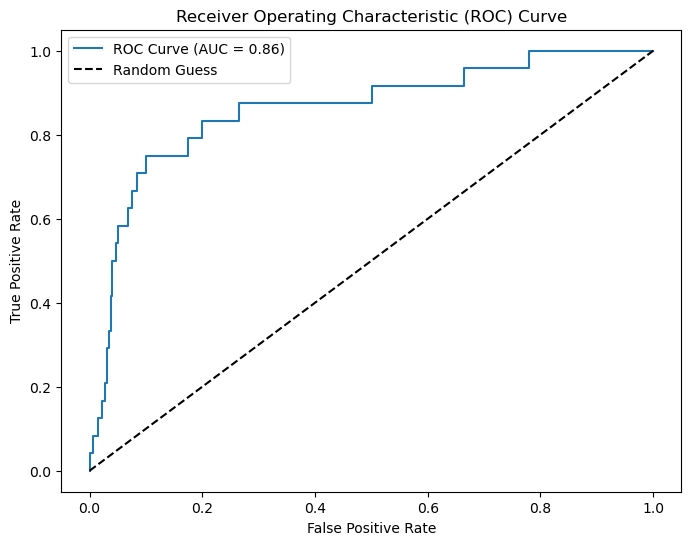

Model Coefficients (alpha = 1):
                                       Feature  Coefficient
0                          effort_distance_km    -0.169451
1                            number_observers     0.119409
2                                effort_hours     0.656523
3                                        year    -0.003794
4                                 day_of_year    -0.001766
5                                hours_of_day    -0.103181
6                                 EVI_prev_yr     0.000000
7              umd_tree_cover_loss_ha_prev_yr     0.000008
8   umd_tree_cover_loss_from_fires_ha_prev_yr    -0.000007
9                             tmax_prev_month    -0.141771
10                            tmin_prev_month     0.441106
11                            prec_prev_month    -0.002554
12                      species_observed_prev     0.422592


In [1359]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# Display coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_model.coef_[0]
})
print("Model Coefficients (alpha = 1):\n", coefficients)

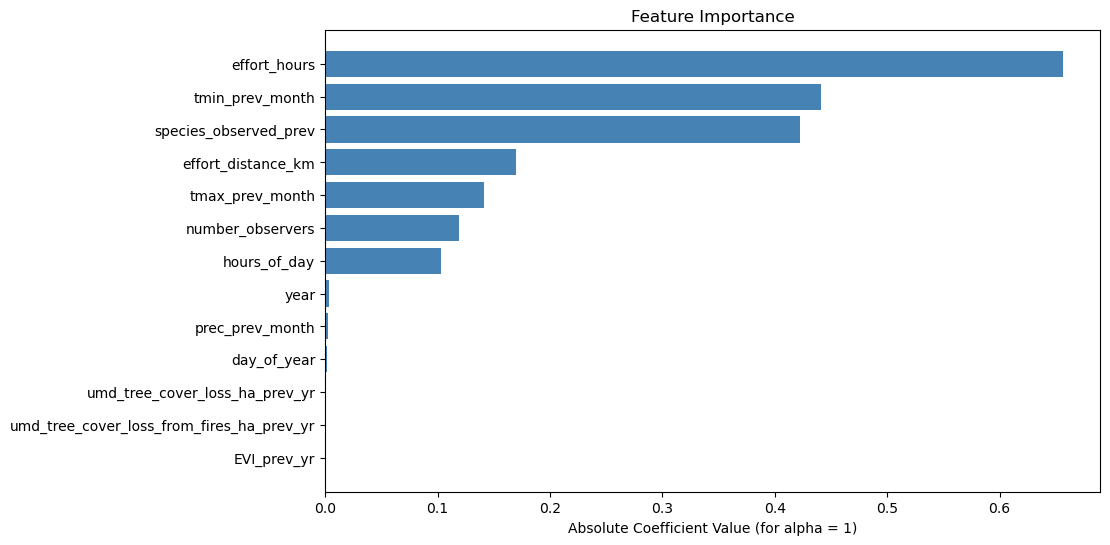

In [1360]:
# Sort coefficients by absolute value for better visualization
coefficients['abs_coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values('abs_coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(coefficients['Feature'], coefficients['abs_coefficient'], color='steelblue')
plt.xlabel('Absolute Coefficient Value (for alpha = 1)')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

Seems like some proof of concept. We have a decent ROC curve and the LASSO does seem to suggest there may be some features to throw away. Now we'll develop on the above test, implementing some cross validation for feature selection (to avoid data leakage) and also looping through several regularization strengths.

Note that our data are time-ordered, so we'll want to use TimeSeriesSplit to get some rolling cross validation.

In [1361]:
# Data set to work with
data = birds_lip_v_train_shifted_69

# Set some regularization strengths to loop through
alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10,25,50,100,1000,10000]

# Number of CV splits
splits = 5

#array to hold LASSO coefficients
coefs = np.empty((splits, len(alphas),len(features)))

j = 0 # alpha counter
for alpha in alphas:
    
    # Set up cross-validation (our data are time-ordered, so we need use TimeSeriesSplit)
    tss = TimeSeriesSplit(n_splits = splits)
    
    i = 0 # split counter
    for train_index, test_index in tss.split(data):
        data_tt = data.iloc[train_index]
        data_ho = data.iloc[test_index]    
        
        X_tt = data_tt[features]
        y_tt = data_tt.species_observed

        # scale the features to help with regularization  (all our features are numerical)
        scaler = StandardScaler() 
        X_tt_scaled = scaler.fit_transform(X_tt)

        # Initialize and train logistic regression with LASSO regularization (L1 penalty)
        # Note the argument 'C' is the inverse of regularization strength
        lasso_log = LogisticRegression(penalty='l1', C = 1/alpha, solver='liblinear', class_weight = 'balanced',
                                       random_state=366, max_iter=10000)
        lasso_log.fit(X_tt_scaled, y_tt)

    
        coefs[i, j, :] = lasso_log.coef_
    
        i += 1
    j += 1
# Get the means of the LASSO coefficients over the cross-validation
coef_means = coefs.mean(axis = 0)

# Convert to a dataframe for readability
cv_coefs = pd.DataFrame(np.round(coef_means,8),
            columns = X.columns,
            index = ["alpha=" + str(a) for a in alphas])

cv_coefs

,effort_distance_km,number_observers,effort_hours,year,day_of_year,hours_of_day,EVI_prev_yr,umd_tree_cover_loss_ha_prev_yr,umd_tree_cover_loss_from_fires_ha_prev_yr,tmax_prev_month,tmin_prev_month,prec_prev_month,species_observed_prev
alpha=1e-05,-0.525462,0.353538,1.191653,0.041213,0.410673,-0.440681,0.127683,0.045163,-0.007173,-1.749918,1.564992,-1.440358,0.129581
alpha=0.0001,-0.525445,0.353530,1.191635,0.042834,0.410558,-0.440666,0.126731,0.043729,-0.005521,-1.749429,1.564657,-1.439815,0.129590
alpha=0.001,-0.525401,0.353453,1.191474,0.054627,0.409809,-0.440614,0.120380,0.031319,0.009071,-1.746364,1.562652,-1.436426,0.129629
alpha=0.01,-0.524775,0.352972,1.190035,0.141811,0.404550,-0.440133,0.092072,-0.100659,0.170239,-1.725845,1.548723,-1.415746,0.129975
alpha=0.1,-0.519432,0.347901,1.176038,0.196377,0.351117,-0.435361,0.068628,-0.078472,0.164907,-1.526847,1.415707,-1.210981,0.133293
alpha=1,-0.475577,0.327995,1.095647,0.222783,0.136550,-0.408075,0.105055,0.065648,0.033130,-0.797500,0.880358,-0.654995,0.151897
alpha=10,-0.303964,0.258761,0.843774,0.158200,0.000000,-0.312861,0.065705,0.043036,0.000000,-0.007059,0.220486,-0.138971,0.145435
alpha=25,-0.157401,0.157790,0.657358,0.003582,0.000000,-0.227379,0.000000,0.011094,0.000000,0.004270,0.087879,-0.051107,0.070010
alpha=50,-0.013677,0.062346,0.501450,0.000000,0.000000,-0.134709,0.000000,0.000000,0.000000,0.000000,0.031106,-0.003537,0.013195
alpha=100,0.000000,0.000000,0.320409,0.000000,0.000000,-0.027067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [1362]:
# Find first value of alpha where the coefficient of each feature first went to zero
cv_coefs.ne(0).idxmin().sort_values(ascending=False)

year                                           alpha=50
umd_tree_cover_loss_ha_prev_yr                 alpha=50
tmax_prev_month                                alpha=50
EVI_prev_yr                                    alpha=25
effort_hours                                 alpha=1000
hours_of_day                                 alpha=1000
effort_distance_km                            alpha=100
number_observers                              alpha=100
tmin_prev_month                               alpha=100
prec_prev_month                               alpha=100
species_observed_prev                         alpha=100
day_of_year                                    alpha=10
umd_tree_cover_loss_from_fires_ha_prev_yr      alpha=10
dtype: object

These results seem to suggest we throw away at least 3 features. We'll definitely exlude 'EVI_prev_yr', 'day_of_year', and 'umd_tree_cover_loss_from_fires_ha_prev_yr'. Then we'll take the top 7 features on solid footing, with the next thre features on less-solid footing (but we'll keep them around to try).

In [1363]:
# It seems 'reg_features' are on solid footing with 'maybe_features' possibly important as well. 
reg_features = ['effort_hours', 'hours_of_day', 'effort_distance_km', 'number_observers', 'tmin_prev_month',
                'prec_prev_month', 'species_observed_prev']
maybe_features = ['year', 'umd_tree_cover_loss_ha_prev_yr', 'tmax_prev_month']


Now that we have some feature selection, we'll re-run our logistic regression model through a grid search to find the optimal feature list (whether we use just reg_features or reg_features + maybe_features) as well as the optimal regularization strength.

In [838]:
# Now we run a grid search for the binary logistic regression with the feature lists above and the hyperparameters
data = birds_lip_v_train_shifted_69 

featlist_list = [reg_features, reg_features + maybe_features]
featlist_names = ['reg_features', 'reg_features + maybe_features']

alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10,25,50,100,1000,10000]
i = 0
for featlist in featlist_list:
    params_logreg = [{'logreg__C': [1/alpha for alpha in alphas] }]
    
    pipe = Pipeline([('scaler', StandardScaler()), 
                     ('logreg', LogisticRegression(penalty='l1', solver='liblinear', class_weight = 'balanced',
                                                   random_state=366, max_iter=10000)) ])
        
    gs_logreg = GridSearchCV(estimator = pipe,    
                             param_grid = params_logreg,
                             scoring = 'f1_macro',
                             cv = TimeSeriesSplit(n_splits = 5))
                             
    gs_logreg.fit(data[featlist], data.species_observed)                                                                   
    print('Features: ', featlist_names[i], 'with best params: \n', gs_logreg.best_params_, 'with macro f1 score: ', str(gs_logreg.best_score_))
    i += 1

Features:  reg_features with best params: 
 {'logreg__C': 99999.99999999999} with macro f1 score:  0.6553414437318439
Features:  reg_features + maybe_features with best params: 
 {'logreg__C': 0.1} with macro f1 score:  0.6520663801309532


Our results here suggest we use our logistic regression on the reg_features list with C = 10,000 (alpha = 10^(-5))

Next we'll move on to our next model, the ***balanced random forest.*** This is quite similar to the standard random forest except that it ***draws a bootstrap sample from the minority class and samples the same number from the majority class*** in an effort to improve performance for a class-imbalanced dataset. We run a cross-validation grid search to tune the hyperparameters class weight and sampling strategy (the ratio of the number of samples drawn from the minority class after resampling to the number of samples from the majority class).

Note that we'll run the balanced random forest with the full feature set and not the subset of features we selected for the binary logistic regression. LASSO regularization is a linear model, so we don't expect it to mesh well with non-linear ensemble methods.


In [1364]:
data = birds_lip_v_train_shifted_69

params_brf = [{'max_depth': [5,10,15],
               'min_samples_leaf': [0.05,0.1,0.2,0.3],
               'max_features': ['sqrt', 'log2', None],
               'sampling_strategy': [.2,.3,.4,.5,.6,.7,.8,.9, 'not majority', 'all'],
               'class_weight': ['balanced', 'balanced_subsample']}]

gs_brf = GridSearchCV(estimator = BalancedRandomForestClassifier(n_estimators = 500,
                                                                 bootstrap= True, 
                                                                 random_state = 366,
                                                                 replacement = True),
                      param_grid = params_brf,
                      scoring = 'f1_macro',
                      cv = TimeSeriesSplit(n_splits = 5))

gs_brf.fit(data[features], data.species_observed)                                                                   
print('Best params: \n', gs_brf.best_params_, 'with macro f1 score: ', str(gs_brf.best_score_))

Best params: 
 {'class_weight': 'balanced_subsample', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'sampling_strategy': 'not majority'} with macro f1 score:  0.6535878522484145


The above result suggests we use our balanced random forest model with the parameters:
- 'class_weight': 'balanced_subsample'(balanced here means inversely proportional to class frequencies; subsample means this balanced weight is computed based on the bootstrap sample for every tree grown)
- 'max_depth': 5 
- 'max_features': 'sqrt' 
- 'min_samples_leaf': 0.2,
- 'sampling_strategy': 'not majority' (resamples all classes but the majority class. For us this means just the minority (detection) class

Now that we have tuned our hyperparameters, we can put all our models together to compare (the same cross validation as before, this is just to have everything in one place)

In [1367]:
data = birds_lip_v_train_shifted_69

# Set up cross-validation
tss = TimeSeriesSplit(n_splits = 5)

# Some arrays to hold model evaluation scores (separate arrays for readability)
# Row 0 is the Fscore for the True (Occupied) class, row 1 is the macro-averaged Fscore for both classes
dummy_uniform_scores = np.zeros((2,5))
dummy_stratified_scores = np.zeros((2,5))
logreg_scores = np.zeros((2,5))
brf_scores = np.zeros((2,5))

i = 0
for train_index, test_index in tss.split(data):
    data_tt = data.iloc[train_index]
    data_ho = data.iloc[test_index]
        
    # Baseline with sklearn's DummyClassifier (strategy = 'uniform' -> random guesses)
    dummy_uniform = DummyClassifier(strategy = 'uniform', random_state = 366)
    # Note - doesn't matter what features we pass in to the dummy classifier since it will ignore them anyway
    dummy_uniform.fit(data_tt[features], data_tt.species_observed)
    dummy_uniform_pred = dummy_uniform.predict(data_ho[features])    
    
    dummy_uniform_scores[0,i] = f1_score(y_true = data_ho.species_observed, y_pred = dummy_uniform_pred, pos_label = True, average = 'binary')
    dummy_uniform_scores[1,i] = f1_score(y_true = data_ho.species_observed, y_pred = dummy_uniform_pred, average = 'macro')
    
    #################################
    
    # Baseline with sklearn's DummyClassifier (strategy = 'stratified' -> random guesses stratified by class frequencies)
    dummy_stratified = DummyClassifier(strategy = 'stratified', random_state = 366)
    # Again, doesn't matter what features we pass in to the dummy classifier since it will ignore them anyway
    dummy_stratified.fit(data_tt[features], data_tt.species_observed)
    dummy_stratified_pred = dummy_stratified.predict(data_ho[features])
    
    dummy_stratified_scores[0,i] = f1_score(y_true = data_ho.species_observed, y_pred = dummy_stratified_pred, pos_label = True, average = 'binary')
    dummy_stratified_scores[1,i] = f1_score(y_true = data_ho.species_observed, y_pred = dummy_stratified_pred, average = 'macro')
     
    
    #################################
    
    # Binary Logistic Regression with L1 Regularization
    
    logpipe = Pipeline([('scaler', StandardScaler()), 
                        ('logreg', LogisticRegression(penalty='l1', C = 10000, solver='liblinear', 
                                                      class_weight = 'balanced',
                                                      random_state=366, max_iter=10000)) ])
    
    logpipe.fit(data_tt[reg_features], data_tt.species_observed)
               
    logreg_pred = logpipe.predict(data_ho[reg_features])
    
    logreg_scores[0,i] = f1_score(y_true = data_ho.species_observed, y_pred = logreg_pred, pos_label = True, average = 'binary')
    logreg_scores[1,i] = f1_score(y_true = data_ho.species_observed, y_pred = logreg_pred, average = 'macro')
     
    #################################
    
    # Balanced random forest
    brf = BalancedRandomForestClassifier(n_estimators = 500, 
                                         max_depth = 5,
                                         min_samples_leaf = 0.2, 
                                         max_features = 'sqrt',
                                         bootstrap= True, 
                                         random_state = 366,
                                         replacement = True,
                                         sampling_strategy = 'not majority',                                 
                                         class_weight = 'balanced_subsample',
                                         )

    brf.fit(data_tt[reg_features], data_tt.species_observed)
           
    brf_pred = brf.predict(data_ho[reg_features])
    
    brf_scores[0,i] =  f1_score(y_true = data_ho.species_observed, y_pred = brf_pred, pos_label = True, average = 'binary')    
    brf_scores[1,i] =  f1_score(y_true = data_ho.species_observed, y_pred = brf_pred, average = 'macro')    
    
    #################################
                                     
    i += 1
    
        
print('Dummy uniform mean Occupied (True) Fscore: ', dummy_uniform_scores[0,:].mean())
print('Dummy stratified mean Occupied (True) Fscore: ', dummy_stratified_scores[0,:].mean())
print('Logistic regression mean Occupied (True) Fscore: ', logreg_scores[0,:].mean())
#print('Random forest mean Occupied (True) Fscore: ', rf_scores[0,:].mean())
print('Balanced random forest mean Occupied (True) Fscore: ', brf_scores[0,:].mean())
#print('XGBoost mean Occupied (True) Fscore: ', xgb_scores[0,:].mean())
print('-----------------------------')
print('Dummy uniform mean macro-averaged Fscore: ', dummy_uniform_scores[1,:].mean())
print('Dummy stratified mean macro-averaged Fscore: ', dummy_stratified_scores[1,:].mean())
print('Logistic regression mean macro-averaged Fscore: ', logreg_scores[1,:].mean())
#print('Random forest mean macro-averaged Fscore: ', rf_scores[1,:].mean())
print('Balanced random forest mean macro-averaged Fscore: ', brf_scores[1,:].mean())
#print('XGBoost mean macro-averaged Fscore: ', xgb_scores[1,:].mean())


Dummy uniform mean Occupied (True) Fscore:  0.18459802828396246
Dummy stratified mean Occupied (True) Fscore:  0.06157342354063666
Logistic regression mean Occupied (True) Fscore:  0.40941829974088034
Balanced random forest mean Occupied (True) Fscore:  0.41320683270275566
-----------------------------
Dummy uniform mean macro-averaged Fscore:  0.40738319912245985
Dummy stratified mean macro-averaged Fscore:  0.4738801599488663
Logistic regression mean macro-averaged Fscore:  0.6553414437318439
Balanced random forest mean macro-averaged Fscore:  0.6434269118244931


Our best performance (which we are measuring by highest macro F1 score) in the cross validation comes from our binary logistic regression model with L1 regularization, which gave a macro F1 of 0.65534. Note also that the Occupied (True) F1score for the logistic regression model is an improvement over our dummy baselines.

Now we'll see if we can use some other class-balancing techniques to help things further. We will try additionally introducing some additional over/under-sampling techniques. We'll try synthetic minority over-sampling technique (SMOTE) for our minority class and random_undersampling for the majority, along with a combination of the two.

implement SMOTE - synthetic minority over-sampling technique. This offers a way to generate synthetic data for the minority class based on the existing data. The balanced random forest already does sampling of its own to accommodate the class imbalance, so we may not expect any improvement there, but perhaps we can improve the binary logistic regression model. 

In [1187]:
data = birds_lip_v_train_shifted_69
rand = 888

# Initialize some samplers, note sampling strategy is the desired ratio of the minority class (after resampling)
# to the majority class
sampler0 = RandomUnderSampler(sampling_strategy = 0.25, random_state = rand)
sampler1 = RandomUnderSampler(sampling_strategy = 0.5, random_state = rand)
sampler2 = RandomUnderSampler(sampling_strategy = 0.75, random_state = rand)
sampler3 = RandomUnderSampler(sampling_strategy = 'majority', random_state = rand) 

sampler4 = SMOTE(sampling_strategy = 0.25, random_state = rand)
sampler5 = SMOTE(sampling_strategy = 0.5, random_state = rand)
sampler6 = SMOTE(sampling_strategy = 0.75, random_state = rand)
sampler7 = SMOTE(sampling_strategy = 'not majority', random_state = rand)

sampler8 = impipe([('under', RandomUnderSampler(sampling_strategy = 0.25, random_state = rand)),
                    ('SMOTE', SMOTE(sampling_strategy = 0.5, random_state = rand))])

samplers = [sampler0, sampler1, sampler2, sampler3, sampler4, sampler5, sampler6, sampler7, sampler8]

sampler_names = ['Under1', 'Under2', 'Under3', 'Under4', 'SMOTE1', 'SMOTE2', 'SMOTE3', 'SMOTE4', 'Mixed']
    
j = 0
for sampler in samplers:
    
    # Set up cross-validation 
    tss = TimeSeriesSplit(n_splits = 5)

    # Some arrays to hold model evaluation scores
    # Row 0 is the Fscore for the True (Occupied) class, row 1 is the macro-averaged Fscore for both classes
    logreg_scores = np.zeros((2,5))
    brf_scores = np.zeros((2,5))

    i = 0
    for train_index, test_index in tss.split(data):
        data_tt = data.iloc[train_index]
        data_ho = data.iloc[test_index]

        #################################    

        # Now use our sampler
        X_samp, y_samp = sampler.fit_resample(data_tt[features], data_tt.species_observed)

        #################################

        # Binary Logistic Regression with L1 Regularization on sampled data

        logpipe = Pipeline([('scaler', StandardScaler()), 
                            ('logreg', LogisticRegression(penalty='l1', C = 10000, solver='liblinear', 
                                                          class_weight = 'balanced',
                                                          random_state=366, max_iter=10000)) ])

        logpipe.fit(X_samp[reg_features], y_samp)
        logreg_pred = logpipe.predict(data_ho[reg_features])

        logreg_scores[0,i] = f1_score(y_true = data_ho.species_observed, y_pred = logreg_pred, pos_label = True, average = 'binary')
        logreg_scores[1,i] = f1_score(y_true = data_ho.species_observed, y_pred = logreg_pred, average = 'macro')

        #################################

        # Balanced random forest to correct for class imbalance
        brf = BalancedRandomForestClassifier(n_estimators = 500, 
                                             max_depth = 5,
                                             min_samples_leaf = 0.2, 
                                             max_features = 'sqrt',
                                             bootstrap= True, 
                                             random_state = 366,
                                             replacement = True,
                                             sampling_strategy = 'not majority',                                 
                                             class_weight = 'balanced_subsample',
                                             )

        brf.fit(X_samp[reg_features], y_samp)
        brf_pred = brf.predict(data_ho[reg_features])

        brf_scores[0,i] =  f1_score(y_true = data_ho.species_observed, y_pred = brf_pred, pos_label = True, average = 'binary')    
        brf_scores[1,i] =  f1_score(y_true = data_ho.species_observed, y_pred = brf_pred, average = 'macro')    



        i += 1
    
    
    
    print(sampler_names[j], ':')
    print('Log reg mean True F1: ', logreg_scores[0,:].mean())
    print('brf mean True F1: ', brf_scores[0,:].mean())
    print('-------------------------')
    print('Log reg mean macro F1: ', logreg_scores[1,:].mean())
    print('brf mean macro F1: ', brf_scores[1,:].mean())
    print('#################################################')
        
        
    j += 1

Under1 :
Log reg mean True F1:  0.38812196426552215
brf mean True F1:  0.42730317169562493
-------------------------
Log reg mean macro F1:  0.6442643745194878
brf mean macro F1:  0.6522920485747093
#################################################
Under2 :
Log reg mean True F1:  0.4017211758173703
brf mean True F1:  0.4211153689155445
-------------------------
Log reg mean macro F1:  0.6490214389368523
brf mean macro F1:  0.6517837293851487
#################################################
Under3 :
Log reg mean True F1:  0.37952318533392837
brf mean True F1:  0.42898520413559604
-------------------------
Log reg mean macro F1:  0.6370579442523564
brf mean macro F1:  0.6553565175759781
#################################################
Under4 :
Log reg mean True F1:  0.40940554740957963
brf mean True F1:  0.41393010256490304
-------------------------
Log reg mean macro F1:  0.651041802250659
brf mean macro F1:  0.6419038793927082
#################################################
SMOTE1 

Logistic regression using SMOTE with sampling_strategy 0.25 seems to be the best. It's only a slight improvement
in the macro F1 score over our logistic regression without oversampling, but we'll elect to take the version
SMOTE as our final model. 

We know that eBird detection frequencies, though sometimes very small, can also vary 
quite a bit (recall the figure we generated just before implementing our binary logistic regression model for the first time). SMOTE with a sampling strategy of 0.25 is meaningless if the ratio the minority class to the majority class already has a greater value than this, so we'll implement conditional SMOTE to accomodate this. If the class minority/majority ratio is already at a value above our 0.25 threshold, we simply will not resample, and our model reduces to the original binary logistic regression from before.

Now we implement this model in the cell below, as a part of the final_test function in order to evaluate our test set. For a sense of model performance, we also include the baseline dummy performance on the test set.

In [1368]:
# Just a convenience function to run our final evaluation on the test set for our two baseline models and
# our binary logistic regression with L1 regularization and (conditional) SMOTE

def final_test(train, test, rand = 88):
    """
    train: training set for a particular species at a particular site
    test: test set for a particular species at a particular site
    """
    
    site = train.Site_ID.unique()[0]
    species = train.scientific_name.unique()[0]
    
    scores = np.zeros((1,8))
    
    # Baseline with sklearn's DummyClassifier (strategy = 'uniform' -> random guesses)
    dummy_uniform = DummyClassifier(strategy = 'uniform', random_state = rand)
    # Note - doesn't matter what features we pass in to the dummy classifier since it will ignore them anyway
    dummy_uniform.fit(train[features], train.species_observed)
    dummy_uniform_pred = dummy_uniform.predict(test[features])    

    dummy_uniform_final_f1_true = f1_score(y_true = test.species_observed, y_pred = dummy_uniform_pred, pos_label = True, average = 'binary')
    dummy_uniform_final_f1_macro = f1_score(y_true = test.species_observed, y_pred = dummy_uniform_pred, average = 'macro')

    #################################

    # Baseline with sklearn's DummyClassifier (strategy = 'stratified' -> random guesses stratified by class frequencies)
    dummy_stratified = DummyClassifier(strategy = 'stratified', random_state = rand)
    # Again, doesn't matter what features we pass in to the dummy classifier since it will ignore them anyway
    dummy_stratified.fit(train[features], train.species_observed)
    dummy_stratified_pred = dummy_stratified.predict(test[features])

    dummy_stratified_final_f1_true = f1_score(y_true = test.species_observed, y_pred = dummy_stratified_pred, pos_label = True, average = 'binary')
    dummy_stratified_final_f1_macro = f1_score(y_true = test.species_observed, y_pred = dummy_stratified_pred, average = 'macro')

    #################################
    
    # Check minority class frequency in test set. If less than our 0.25 threshold, oversample with SMOTE
    if train.species_observed.value_counts()[True]/train.species_observed.value_counts()[False] < 0.25:
        # Class ratio sufficiently small, initialize our sampler (we'll still resample even if one resampling
        # pushes us over 0.25)
        # Will handle this with numbers of samples rather than fractions because smote is a little picky
        old_true = train.species_observed.value_counts()[True]
        old_false = train.species_observed.value_counts()[False]

        new_true = int(0.25*old_false)
        new_false = old_false

        samp = {0: new_false, 1: new_true}

        
        smote = SMOTE(sampling_strategy = samp, random_state = rand)
        X_samp, y_samp = smote.fit_resample(train[features], train.species_observed)
    else:
        X_samp, y_samp = train[features], train.species_observed
    #################################

    # Binary Logistic Regression with L1 Regularization (and maybe SMOTE)

    logpipe = Pipeline([('scaler', StandardScaler()), 
                        ('logreg', LogisticRegression(penalty='l1', C = 10000, solver='liblinear', 
                                                      class_weight = 'balanced',
                                                      random_state=366, max_iter=10000)) ])

    #logpipe.fit(train[reg_features], train.species_observed)
    logpipe.fit(X_samp[reg_features], y_samp)

    logreg_pred = logpipe.predict(test[reg_features])

    logreg_final_f1_true = f1_score(y_true = test.species_observed, y_pred = logreg_pred, pos_label = True, average = 'binary')
    logreg_final_f1_macro = f1_score(y_true = test.species_observed, y_pred = logreg_pred, average = 'macro')

    
    #################################


    scores[0,1] = site
    scores[0,2] = dummy_uniform_final_f1_true
    scores[0,3] = dummy_stratified_final_f1_true
    scores[0,4] = logreg_final_f1_true

    scores[0,5] = dummy_uniform_final_f1_macro
    scores[0,6] = dummy_stratified_final_f1_macro
    scores[0,7] = logreg_final_f1_macro
    
    df = pd.DataFrame(scores, columns = ['species', 'site', 'dummy_u_true', 'dummy_s_true', 'logreg_true',
                                         'dummy_u_macro', 'dummy_s_macro',  'logreg_macro'])
    df.species = species
    return df



In [1369]:
final_test(birds_lip_v_train_shifted_69, birds_lip_v_test_shifted_69)

,species,site,dummy_u_true,dummy_s_true,logreg_true,dummy_u_macro,dummy_s_macro,logreg_macro
0,Lipaugus vociferans,69.0,0.027682,0.022727,0.178571,0.335315,0.467841,0.566737


In the above cell we have our performance on the test set. Note the first two columns are the species and site. The next three columns present the F1 scores for the True (Detection) class for the two baseline models and our logistic regression model. The last three columns show the corresponding macro-averaged F1 scores for these three models.

Compared to our logistic regression model's average cross-validation macro F1 score of 0.663651, we see we have some decrease in performance on the test set, with the last column logreg_macro showing 0.566737. 

The decrease in performance on the test set may be impacted by the class imbalance in the test set. We have seen that the detection frequency has tended strongly down in recent years (the figure from earlier has been reproduced in the cell below). As our data is time-ordered, our test set is comprised of the most recent 20% of the dataset. And because the data are more skewed toward recency (many more observations in more recent years than past years), the detection frequency in our test set will be significantly lower than the average detection frequency in our training set, which is skewed higher by the trend of greater detection frequency from, say, 2015-2018.

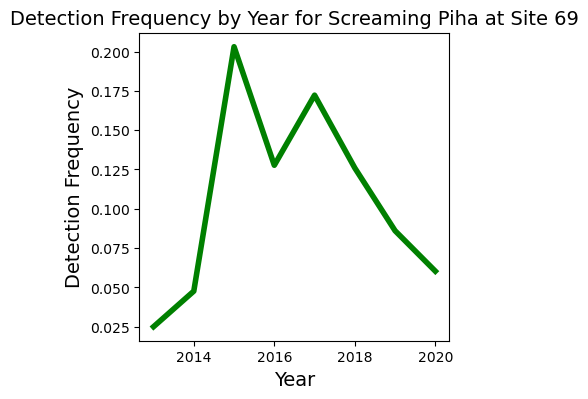

In [1370]:
det_freqs = []
for year in birds_lip_v_train_shifted_69.year.unique():
    det_freqs.append(data.loc[data.year == year, 'species_observed'].value_counts(normalize=True)[True] )
fig = plt.figure(figsize = (4,4))
plt.plot(data.year.unique(), det_freqs, c='g', linewidth=4)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Detection Frequency', fontsize = 14)
plt.title('Detection Frequency by Year for Screaming Piha at Site 69', fontsize = 14)
plt.savefig('detectionfreq_lipv_69.png', format = 'png')
plt.show()

Let's move on and see how our model (recall it was selected using data from only one site) generalizes to other sites

In [1322]:
# Now let's see how our model generalizes to the other three sites of interest
results_lip_v = pd.concat([final_test(birds_lip_v_train_shifted_69,birds_lip_v_test_shifted_69),
                           final_test(birds_lip_v_train_shifted_68,birds_lip_v_test_shifted_68),
                           final_test(birds_lip_v_train_shifted_78,birds_lip_v_test_shifted_78),
                           final_test(birds_lip_v_train_shifted_79,birds_lip_v_test_shifted_79)])


In [1323]:
results_lip_v

,species,site,dummy_u_true,dummy_s_true,logreg_true,dummy_u_macro,dummy_s_macro,logreg_macro
0,Lipaugus vociferans,69.0,0.027682,0.022727,0.178571,0.335315,0.467841,0.566737
0,Lipaugus vociferans,68.0,0.166667,0.000000,0.500000,0.365942,0.351852,0.539474
0,Lipaugus vociferans,78.0,0.300000,0.166667,0.500000,0.504167,0.494048,0.696429
0,Lipaugus vociferans,79.0,0.349206,0.254545,0.642857,0.458814,0.428244,0.723389


Relative to our logistic regression model’s performance on the test set for the site with which it was selected (site 69), we find no significant decrease in performance (macro-averaged F1 score) when evaluating our model on the other three sites for Screaming piha, and in some cases we find non-trivial improvement. 

Thus for the Screaming piha species our model generalizes by site fairly well. This is not so surprising since all four of our sites are clustered fairly close together, so we might not expect too much variability in the covariates between them.

Now let's see how our model generalizes to our other species, the Black vulture (Coragyps atratus)

In [1275]:
# Now how do we generalize to another species?
results_cor_a = pd.concat([final_test(birds_cor_a_train_shifted_69,birds_cor_a_test_shifted_69),
                           final_test(birds_cor_a_train_shifted_68,birds_cor_a_test_shifted_68),
                           final_test(birds_cor_a_train_shifted_78,birds_cor_a_test_shifted_78),
                           final_test(birds_cor_a_train_shifted_79,birds_cor_a_test_shifted_79)])

In [1276]:
results_cor_a

,species,site,dummy_u_true,dummy_s_true,logreg_true,dummy_u_macro,dummy_s_macro,logreg_macro
0,Coragyps atratus,69.0,0.417323,0.411765,0.546296,0.456961,0.480076,0.625558
0,Coragyps atratus,68.0,0.272727,0.133333,0.380952,0.445887,0.434014,0.539313
0,Coragyps atratus,78.0,0.384615,0.117647,0.384615,0.492308,0.405762,0.492308
0,Coragyps atratus,79.0,0.204082,0.000000,0.190476,0.438175,0.412587,0.460317


We find reasonably consistent performance when evaluating on our second species, Black vulture. Compared to our model’s performance on the test set for the species and site with which it was selected (Lipaugus vociferans, site 69), sites 78 and 79 for Black vulture show a slight decrease in performance based on macro-averaged F1 score. Our generalization from the forest specialist, 'Lipaugus vociferans,' to the generalist 'Coragyps atratus' was reasonable.

That's it!
In summary, we find that of the traditional machine learning classification approaches we implemented, binary logistic regression with L1 regularization and SMOTE performed best in cross-validation testing. The model was selected using the Screaming piha and a single site. It generalizes to other sites for the Screaming piha quite well, and generalizes somewhat to our second species, the Black vulture.